In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import wave

TensorFlow version: 2.6.0


In [3]:
import librosa
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout

import IPython.display as ipd

In [4]:
#importing  libraries
#Keras
import tensorflow.keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

#sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Others
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import tensorflow as tf
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd
import csv
from tqdm import tqdm
import os


import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
#from include import helpers

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
#split the dataset into train and test
X_train = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/X_train_all.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/y_train_all.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/X_test_all.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/y_test_all.csv')
#take a peak at the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4499, 42), (4499, 1), (4233, 43), (4233, 2))

In [6]:
#One hot encode labels

le = LabelEncoder()

def encoding_y(data):
  data = np.array(data['label'])
  data = to_categorical(le.fit_transform(data))
  return data

y_train = encoding_y(y_train)
y_test = encoding_y(y_test) 

In [7]:
X_test = X_test.iloc[:,1:43]
#normalization (helps with exploding gradient); good as we are mixing a lot of datasets
def standardization(data):
  mean = np.mean(data,axis=0)
  std = np.std(data, axis=0)
  data =( data - mean)/std
  data = np.array(data)
  return data

X_train = standardization(X_train)
X_test = standardization(X_test)


In [8]:
model = Sequential()
model.add(layers.Dense(1000, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(750, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_rmp = tensorflow.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              43000     
_________________________________________________________________
dense_1 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5

In [9]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              43000     
_________________________________________________________________
dense_1 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4499, 42), (4233, 42), (4499, 10), (4233, 10))

In [11]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 250
num_batch_size = 256
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model_all=model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/250
18/18 [==============================] - 3s 78ms/step - loss: 1.6857 - accuracy: 0.4359 - val_loss: 1.8840 - val_accuracy: 0.4009

Epoch 00001: val_loss improved from inf to 1.88397, saving model to .\audio_classification.hdf5
Epoch 2/250
18/18 [==============================] - 1s 37ms/step - loss: 0.8338 - accuracy: 0.7335 - val_loss: 1.8322 - val_accuracy: 0.5107

Epoch 00002: val_loss improved from 1.88397 to 1.83222, saving model to .\audio_classification.hdf5
Epoch 3/250
18/18 [==============================] - 1s 40ms/step - loss: 0.5064 - accuracy: 0.8351 - val_loss: 1.9908 - val_accuracy: 0.5448

Epoch 00003: val_loss did not improve from 1.83222
Epoch 4/250
18/18 [==============================] - 1s 36ms/step - loss: 0.3249 - accuracy: 0.8953 - val_loss: 2.4795 - val_accuracy: 0.5370

Epoch 00004: val_loss did not improve from 1.83222
Epoch 5/250
18/18 [==============================] - 1s 36ms/step - loss: 0.2349 - accuracy: 0.9242 - val_loss: 2.8295 - val_accur


Epoch 00042: val_loss did not improve from 1.83222
Epoch 43/250
18/18 [==============================] - 1s 44ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 4.7773 - val_accuracy: 0.5485

Epoch 00043: val_loss did not improve from 1.83222
Epoch 44/250
18/18 [==============================] - 1s 42ms/step - loss: 9.1408e-04 - accuracy: 0.9993 - val_loss: 4.8078 - val_accuracy: 0.5507

Epoch 00044: val_loss did not improve from 1.83222
Epoch 45/250
18/18 [==============================] - 1s 48ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 4.8777 - val_accuracy: 0.5502

Epoch 00045: val_loss did not improve from 1.83222
Epoch 46/250
18/18 [==============================] - 1s 50ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 4.8465 - val_accuracy: 0.5563

Epoch 00046: val_loss did not improve from 1.83222
Epoch 47/250
18/18 [==============================] - 1s 45ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 4.9467 - val_accuracy: 0.5516

Epoch 00047: val_los

18/18 [==============================] - 1s 48ms/step - loss: 8.1304e-04 - accuracy: 0.9993 - val_loss: 6.0259 - val_accuracy: 0.5542

Epoch 00084: val_loss did not improve from 1.83222
Epoch 85/250
18/18 [==============================] - 1s 44ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 6.1903 - val_accuracy: 0.5507

Epoch 00085: val_loss did not improve from 1.83222
Epoch 86/250
18/18 [==============================] - 1s 51ms/step - loss: 8.8986e-04 - accuracy: 0.9993 - val_loss: 6.2116 - val_accuracy: 0.5471

Epoch 00086: val_loss did not improve from 1.83222
Epoch 87/250
18/18 [==============================] - 1s 51ms/step - loss: 8.9259e-04 - accuracy: 0.9996 - val_loss: 6.0403 - val_accuracy: 0.5530

Epoch 00087: val_loss did not improve from 1.83222
Epoch 88/250
18/18 [==============================] - 1s 45ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 6.1396 - val_accuracy: 0.5530

Epoch 00088: val_loss did not improve from 1.83222
Epoch 89/250
18/18 [======

18/18 [==============================] - 1s 50ms/step - loss: 6.5935e-04 - accuracy: 0.9996 - val_loss: 6.7985 - val_accuracy: 0.5485

Epoch 00125: val_loss did not improve from 1.83222
Epoch 126/250
18/18 [==============================] - 1s 41ms/step - loss: 7.6561e-04 - accuracy: 0.9996 - val_loss: 6.8315 - val_accuracy: 0.5511

Epoch 00126: val_loss did not improve from 1.83222
Epoch 127/250
18/18 [==============================] - 1s 47ms/step - loss: 7.1231e-04 - accuracy: 0.9993 - val_loss: 6.8144 - val_accuracy: 0.5519

Epoch 00127: val_loss did not improve from 1.83222
Epoch 128/250
18/18 [==============================] - 1s 48ms/step - loss: 6.6136e-04 - accuracy: 0.9996 - val_loss: 6.8284 - val_accuracy: 0.5507

Epoch 00128: val_loss did not improve from 1.83222
Epoch 129/250
18/18 [==============================] - 1s 44ms/step - loss: 6.6776e-04 - accuracy: 0.9996 - val_loss: 6.8319 - val_accuracy: 0.5516

Epoch 00129: val_loss did not improve from 1.83222
Epoch 130/250


18/18 [==============================] - 1s 47ms/step - loss: 6.6510e-04 - accuracy: 0.9993 - val_loss: 6.9930 - val_accuracy: 0.5490

Epoch 00166: val_loss did not improve from 1.83222
Epoch 167/250
18/18 [==============================] - 1s 44ms/step - loss: 7.4561e-04 - accuracy: 0.9991 - val_loss: 6.9615 - val_accuracy: 0.5509

Epoch 00167: val_loss did not improve from 1.83222
Epoch 168/250
18/18 [==============================] - 1s 41ms/step - loss: 6.5252e-04 - accuracy: 0.9996 - val_loss: 6.9436 - val_accuracy: 0.5526

Epoch 00168: val_loss did not improve from 1.83222
Epoch 169/250
18/18 [==============================] - 1s 51ms/step - loss: 6.4998e-04 - accuracy: 0.9996 - val_loss: 6.8959 - val_accuracy: 0.5587

Epoch 00169: val_loss did not improve from 1.83222
Epoch 170/250
18/18 [==============================] - 1s 49ms/step - loss: 7.1034e-04 - accuracy: 0.9993 - val_loss: 6.9074 - val_accuracy: 0.5571

Epoch 00170: val_loss did not improve from 1.83222
Epoch 171/250


18/18 [==============================] - 1s 48ms/step - loss: 6.2457e-04 - accuracy: 0.9993 - val_loss: 7.2813 - val_accuracy: 0.5554

Epoch 00207: val_loss did not improve from 1.83222
Epoch 208/250
18/18 [==============================] - 1s 49ms/step - loss: 6.4954e-04 - accuracy: 0.9993 - val_loss: 7.2531 - val_accuracy: 0.5578

Epoch 00208: val_loss did not improve from 1.83222
Epoch 209/250
18/18 [==============================] - 1s 38ms/step - loss: 7.3818e-04 - accuracy: 0.9991 - val_loss: 7.3368 - val_accuracy: 0.5523

Epoch 00209: val_loss did not improve from 1.83222
Epoch 210/250
18/18 [==============================] - 1s 51ms/step - loss: 6.6741e-04 - accuracy: 0.9996 - val_loss: 7.2899 - val_accuracy: 0.5540

Epoch 00210: val_loss did not improve from 1.83222
Epoch 211/250
18/18 [==============================] - 1s 49ms/step - loss: 6.7609e-04 - accuracy: 0.9996 - val_loss: 7.1649 - val_accuracy: 0.5575

Epoch 00211: val_loss did not improve from 1.83222
Epoch 212/250



Epoch 00248: val_loss did not improve from 1.83222
Epoch 249/250
18/18 [==============================] - 1s 59ms/step - loss: 7.3076e-04 - accuracy: 0.9996 - val_loss: 6.7391 - val_accuracy: 0.5405

Epoch 00249: val_loss did not improve from 1.83222
Epoch 250/250
18/18 [==============================] - 1s 64ms/step - loss: 7.9139e-04 - accuracy: 0.9996 - val_loss: 6.8553 - val_accuracy: 0.5372

Epoch 00250: val_loss did not improve from 1.83222
Training completed in time:  0:03:37.233848


In [13]:
# Evaluating the model on the training and testing set

score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9995554685592651
Testing Accuracy:  0.5372076630592346


In [14]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.5372076630592346


In [15]:
#model.predict_classes(X_test)
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[3 2 2 ... 1 1 1]


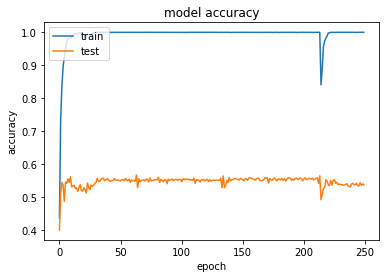

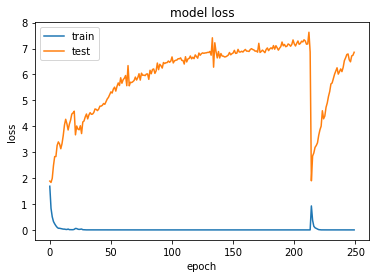

In [16]:
# summarize history for accuracy
plt.plot(model_all.history['accuracy'])
plt.plot(model_all.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_all.history['loss'])
plt.plot(model_all.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Avg Test accuracy and Standart Devision 

In [17]:
train_hist = pd.DataFrame(model_all.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,1.685660,0.435875,1.883974,0.400898
1,0.833777,0.733496,1.832224,0.510749
2,0.506403,0.835074,1.990792,0.544767
3,0.324858,0.895310,2.479514,0.536971
4,0.234879,0.924205,2.829546,0.487361
...,...,...,...,...
245,0.001191,0.999555,6.560355,0.534137
246,0.001030,0.999555,6.486380,0.543586
247,0.000823,0.999555,6.714815,0.535790
248,0.000731,0.999555,6.739059,0.540515


In [18]:
print(train_hist["val_accuracy"].describe())

count    250.000000
mean       0.547338
std        0.014546
min        0.400898
25%        0.543704
50%        0.551618
75%        0.554394
max        0.567446
Name: val_accuracy, dtype: float64


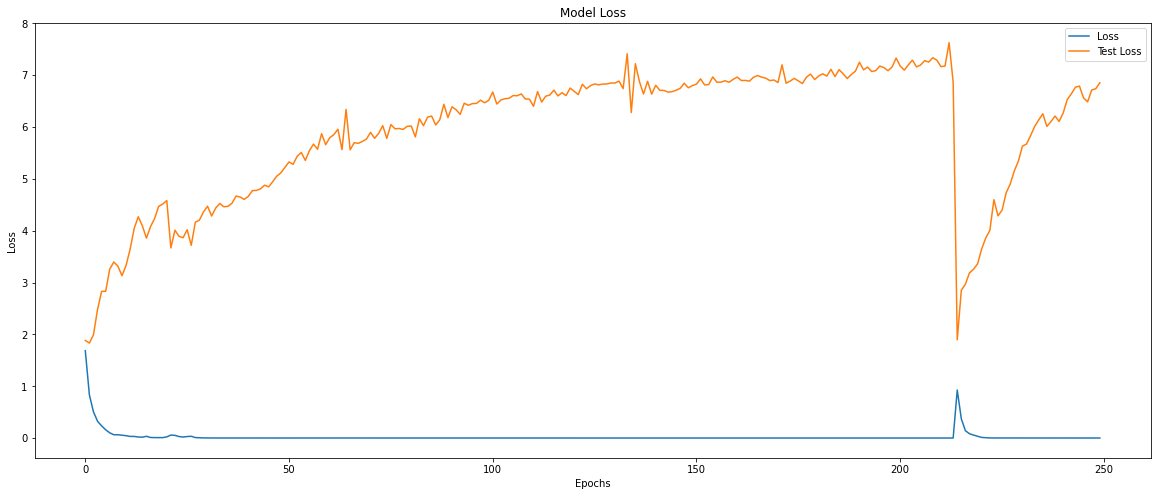

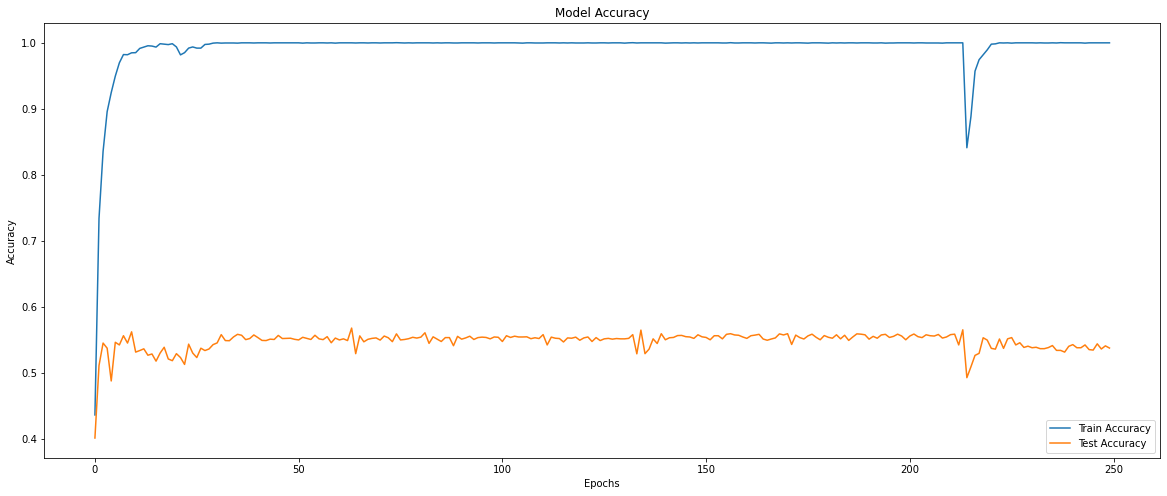

In [19]:
plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['Loss','Test Loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['Train Accuracy','Test Accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [20]:
ytrue = np.argmax(y_test,axis=1)
ypred = np.argmax(model.predict(X_test),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))


Confusion Matrix :


[[128   3  51  74  50  14  22  10  14 134]
 [  4 170   1   5   2   3   0   1   0  35]
 [ 11   1 322  54  11  15   5   9  26  46]
 [ 27   4  40 339  22  10  11   2  26  19]
 [  9   3  28  36 233  13   8  75  10  85]
 [ 76  11  42  54  25 186   7   6  12  64]
 [  4   0   1  21   4   2 151   0   0   1]
 [ 18   0   3  10 198  19  31 127  20  26]
 [  2   0   8  89   1  10   0   0 243  40]
 [ 17   4  41  25  19   5   0   1  13 375]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.43      0.26      0.32       500
           1       0.87      0.77      0.82       221
           2       0.60      0.64      0.62       500
           3       0.48      0.68      0.56       500
           4       0.41      0.47      0.44       500
           5       0.67      0.39      0.49       483
           6       0.64      0.82      0.72       184
           7       0.55      0.28      0.37       452
           8       0.67      0.